In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
!wandb login 9676e3cc95066e4865586082971f2653245f09b4

Appending key for api.wandb.ai to your netrc file: /Users/guydavidson/.netrc
Successfully logged in to Weights & Biases!


In [162]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from scipy.special import factorial

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import path as mpath

import pickle
import tabulate
import wandb
from collections import namedtuple
from scipy.stats import binom_test, wilcoxon

import meta_learning_data_analysis as analysis
import meta_learning_analysis_plots as plots

In [11]:
np.set_printoptions(linewidth=160)

In [13]:
cache = analysis.refresh_cache()
print(cache.keys())

dict_keys(['six_replications_analyses', 'query_mod_replications'])


In [14]:
six_replications_analyses = cache['six_replications_analyses']
query_mod_replications = cache['query_mod_replications']

# No-query modulation, results by dimension

Obviously, there will be a description below each panel explaining:
* More in detail what each column of the plot is signifying
* What the color map/spectrum means in each column
* Why we take log-log plots
* How each of these was computed
* Error bars being SEMs in log-space (SEM(log(# examples))) for each slot, and the respective sample sizes

**Mike** - what would be important to make sure I explain in the caption to the panel, rather than generically somewhere? Does this layout make sense?

In [30]:
MIN_FONT_SIZE = 16
LABELS_FONT_SIZE = 20

matplotlib.rcParams.update({'font.size': MIN_FONT_SIZE})
FONT_DICT = dict(fontsize=LABELS_FONT_SIZE) 

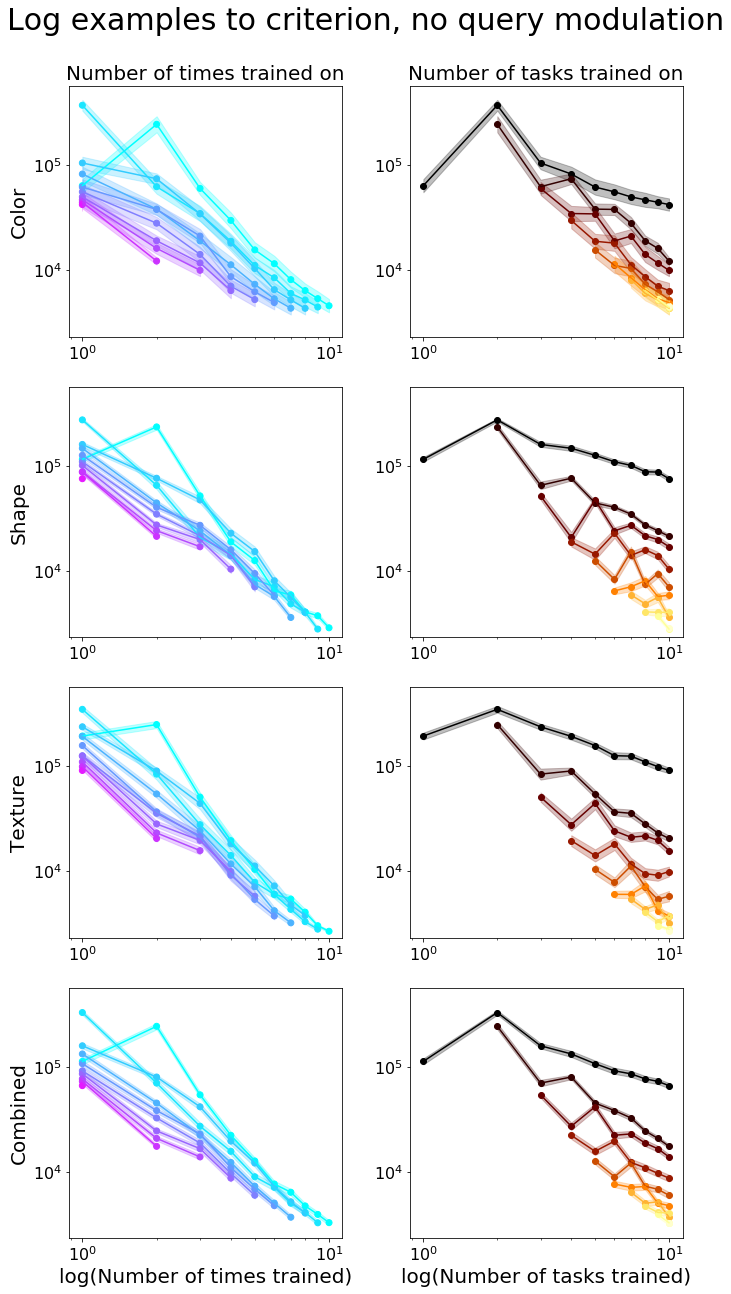

In [62]:
LOG_PLOT_YLIM = (7.75, 13.25)

plots.plot_processed_results_all_dimensions(six_replications_analyses, data_index=1, 
                                            title='Log examples to criterion, no query modulation',
                                            ylim=LOG_PLOT_YLIM, log_x=True, log_y=True, sem_n=(60, 60, 60, 180), shade_error=True,
                                            font_dict=FONT_DICT, times_trained_colormap='cool', tasks_trained_colormap='afmhot')

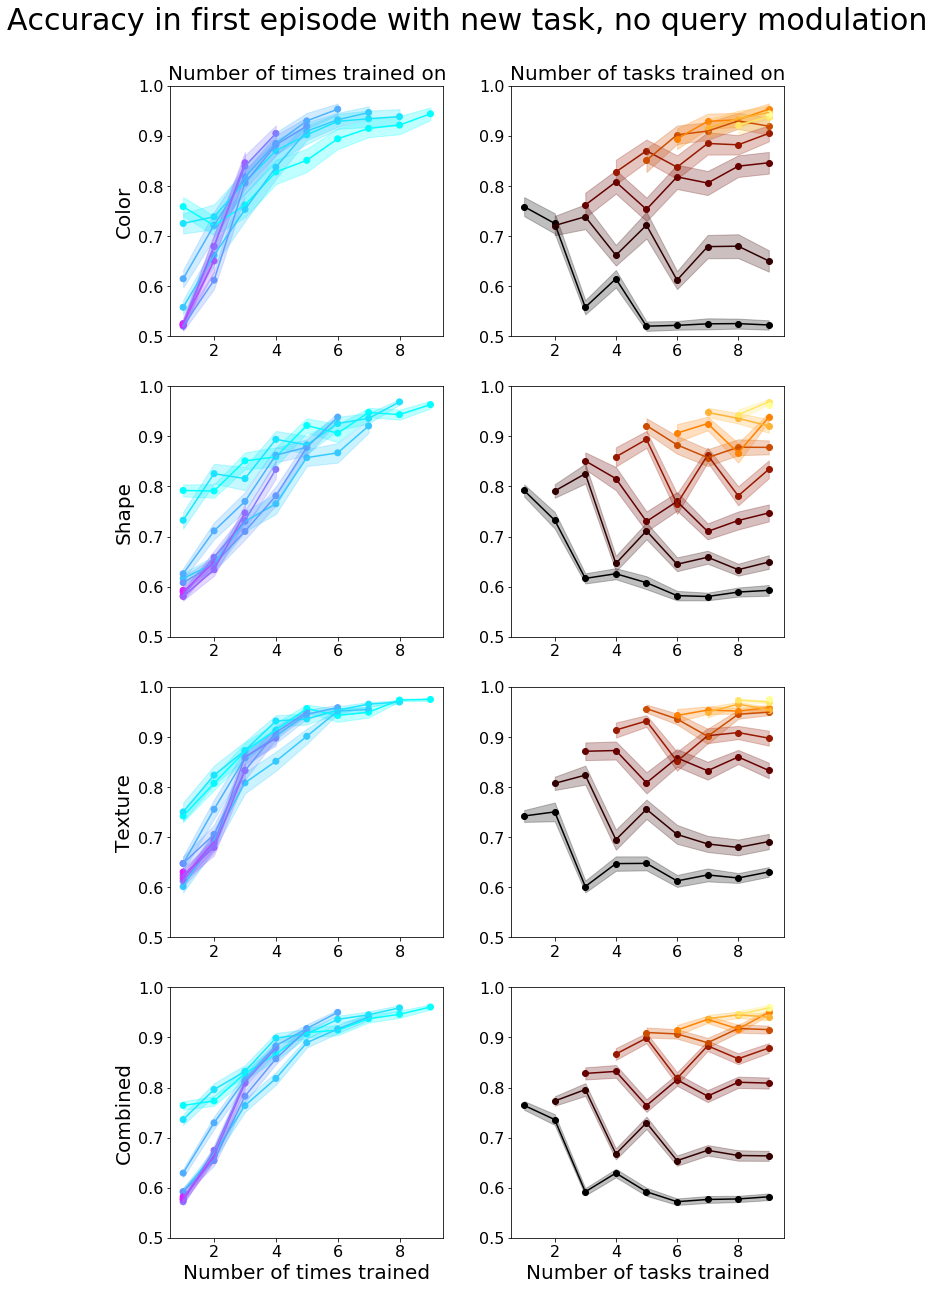

In [63]:
ACCURACY_PLOT_YLIM = (0.5, 1.0)

plots.plot_processed_results_all_dimensions(six_replications_analyses, data_index=2, 
                                            title='Accuracy in first episode with new task, no query modulation',
                                            sem_n=(60, 60, 60, 180), shade_error=True, ylim=ACCURACY_PLOT_YLIM,
                                            font_dict=FONT_DICT, times_trained_colormap='cool', tasks_trained_colormap='afmhot')

# Plot per query-modulation per dimension

I think these will only go in an appendix, to basically say, if you want to see the results broken down by each dimension, they're available, but we're going to only discuss the combined results in the main body of the paper.

**Mike** - a couple of questions here:
* Does the above make sense? Or do these merit including in the main body?
* These are currently the transpose of the above plot. Above I had the different dimensions each in a row, and the two panels as columns. Here I have the modulation levels on the rows, and the dimensions on the columns. This doesn't sound ideal. Should I transpose one of them? If so, which?

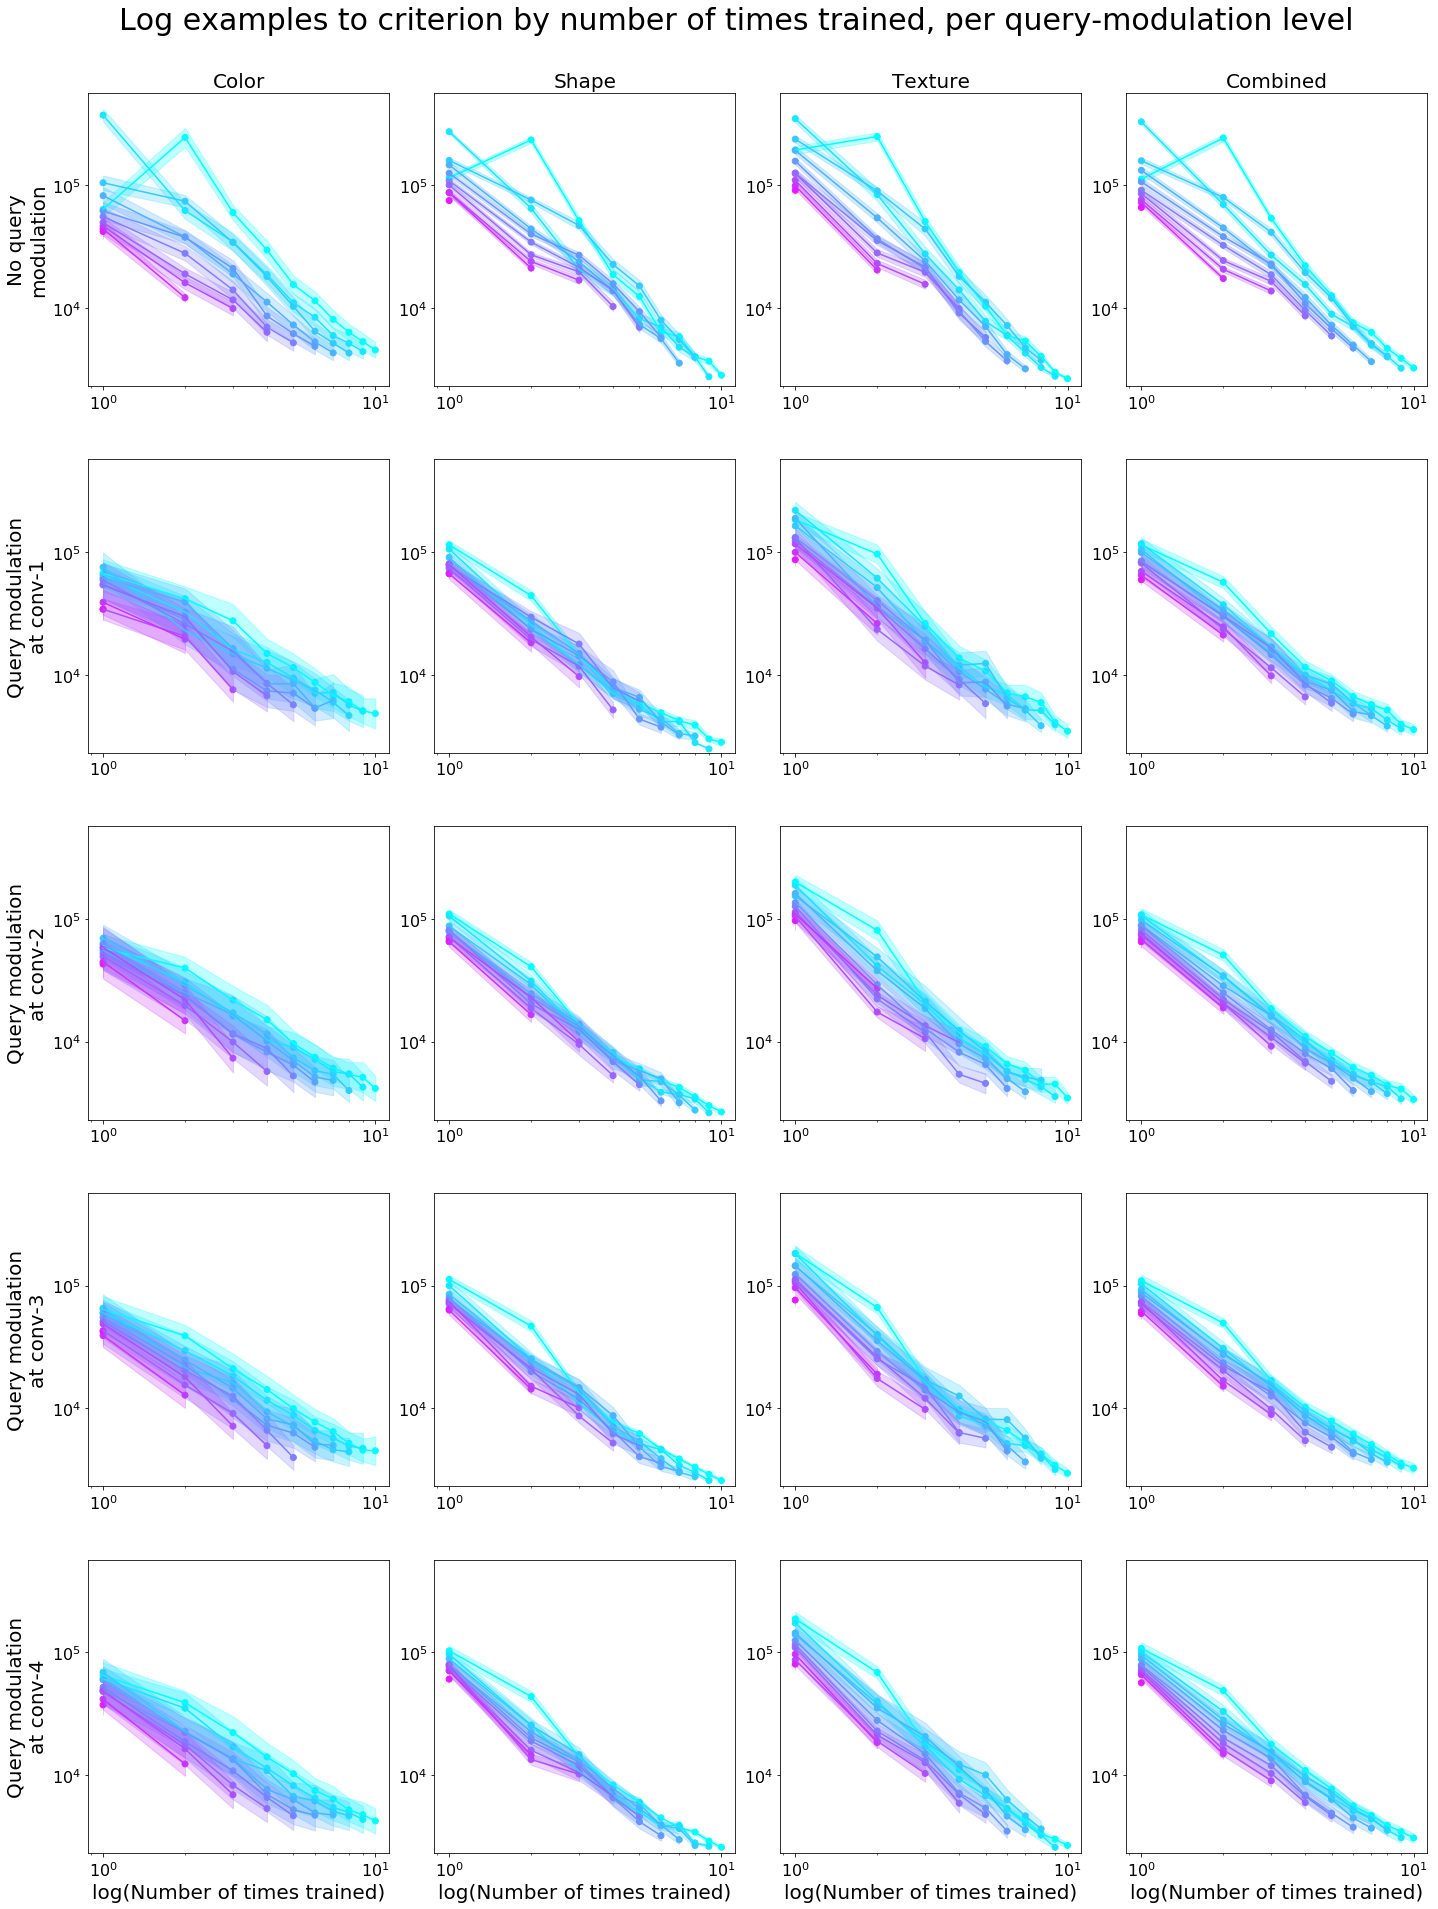

In [65]:
plots.plot_per_model_per_dimension(six_replications_analyses, query_mod_replications, 
                                   plots.examples_by_times_trained_on, 
                                   'Log examples to criterion by number of times trained, per query-modulation level',
                                   FONT_DICT, ylim=LOG_PLOT_YLIM, sem_n=(20, 20, 20, 60), baseline_sem_n=(60, 60, 60, 180),
                                   colormap='cool')

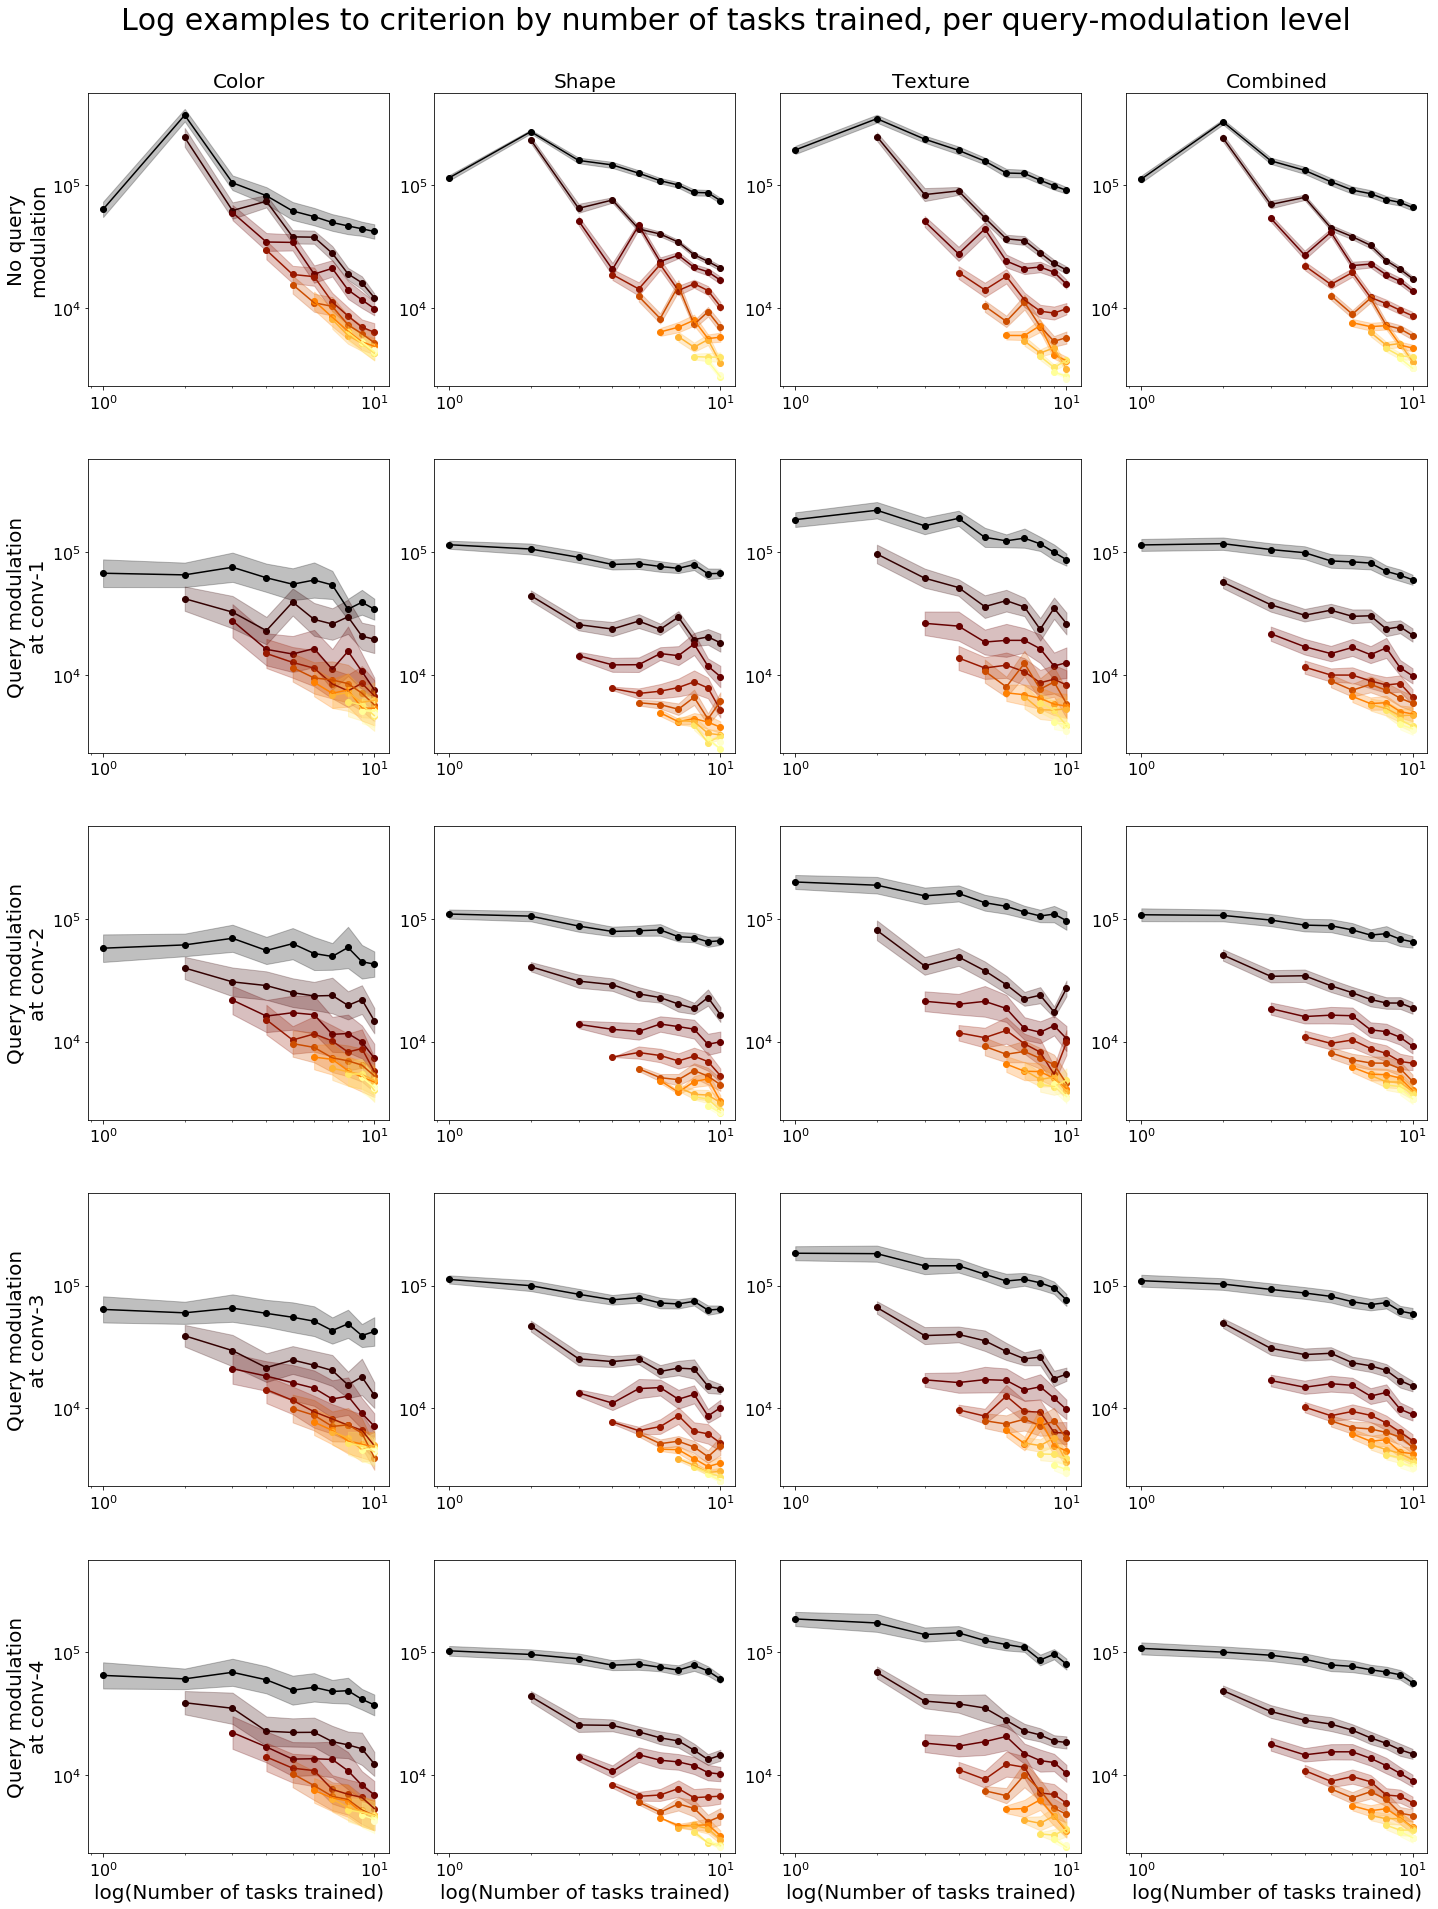

In [66]:
plots.plot_per_model_per_dimension(six_replications_analyses, query_mod_replications, 
                                   plots.examples_by_num_tasks_trained, 
                                   'Log examples to criterion by number of tasks trained, per query-modulation level',
                                   FONT_DICT, ylim=LOG_PLOT_YLIM, sem_n=(20, 20, 20, 60), baseline_sem_n=(60, 60, 60, 180),
                                   colormap='afmhot')

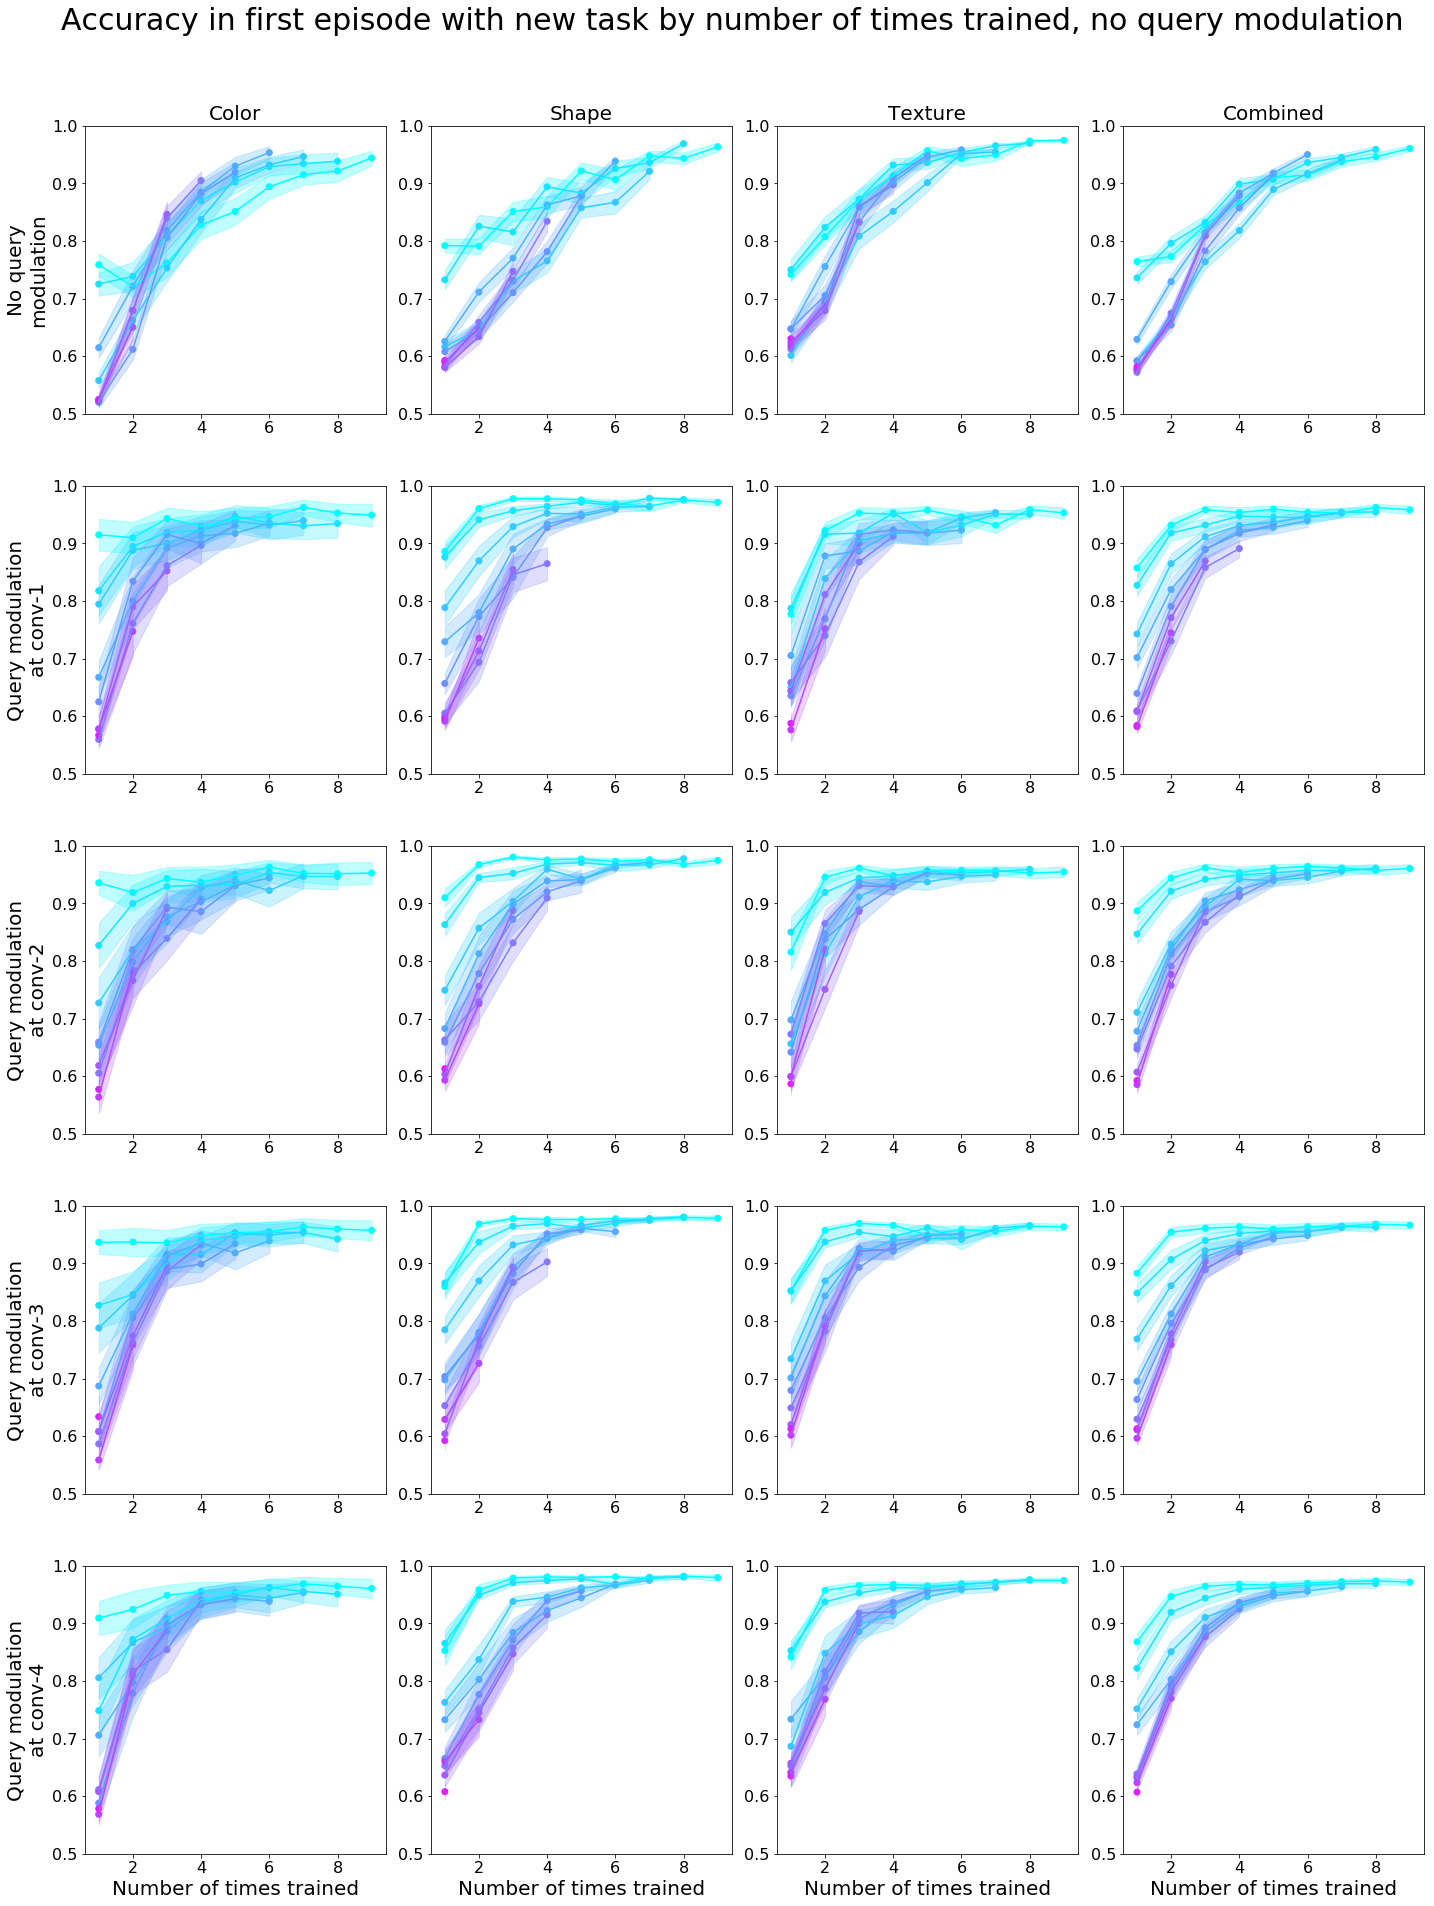

In [59]:
plots.plot_per_model_per_dimension(six_replications_analyses, query_mod_replications, 
                                   plots.examples_by_times_trained_on, 
                                   'Accuracy in first episode with new task by number of times trained, no query modulation',
                                   FONT_DICT, ylim=ACCURACY_PLOT_YLIM, log_x=False, log_y=False, sem_n=(20, 20, 20, 60), baseline_sem_n=(60, 60, 60, 180),
                                   colormap='cool', data_index=2)

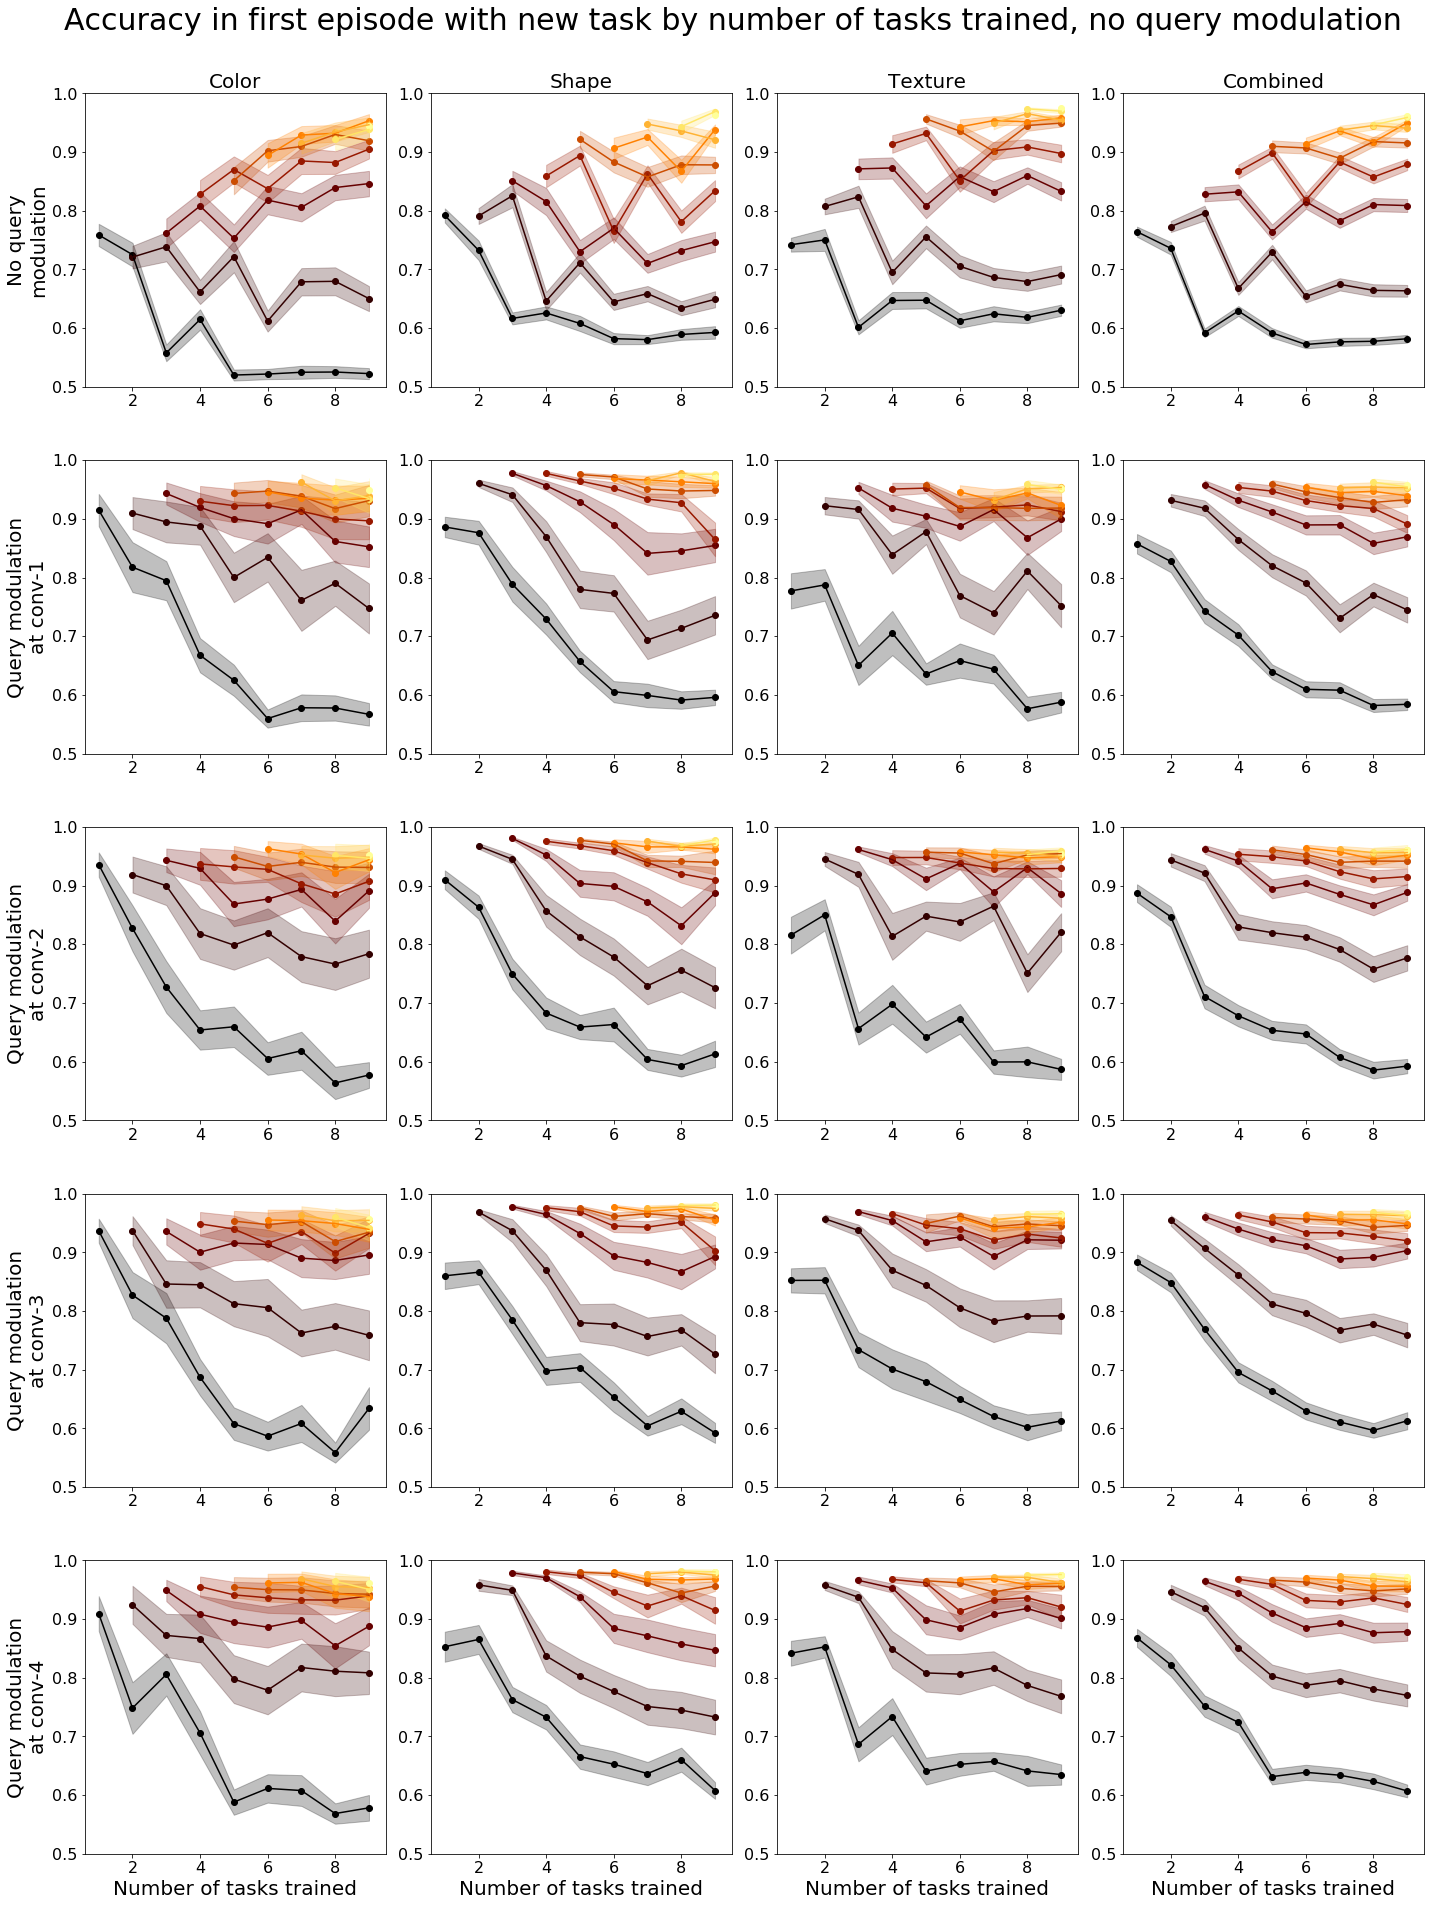

In [67]:
plots.plot_per_model_per_dimension(six_replications_analyses, query_mod_replications, 
                                   plots.examples_by_num_tasks_trained, 
                                   'Accuracy in first episode with new task by number of tasks trained, no query modulation',
                                   FONT_DICT, ylim=ACCURACY_PLOT_YLIM, log_x=False, log_y=False, sem_n=(20, 20, 20, 60), baseline_sem_n=(60, 60, 60, 180),
                                   colormap='afmhot', data_index=2)

# Comparison plots

Comparing to no query modulation

**Mike** - same question as before - do you think there's anything that's really important to explain in the figure text that I might not think about?

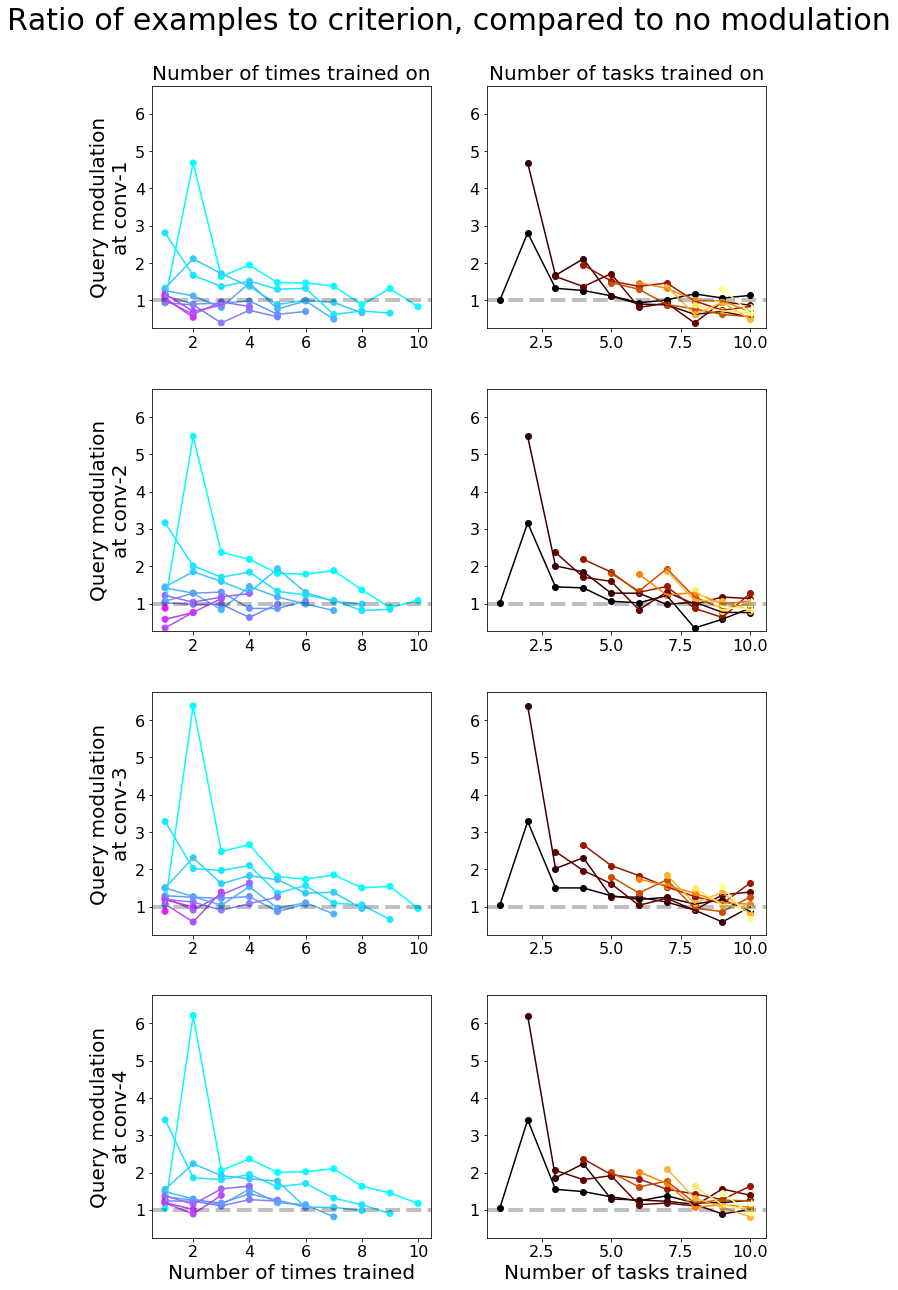

In [96]:
comparison_level = 0

EXAMPLE_RATIO_YLIM = (0.25, 6.75)

plots.combined_comparison_plots(six_replications_analyses, query_mod_replications, 
                                'Ratio of examples to criterion, compared to no modulation',
                                comparison_level, comparison_func=np.divide,
                                font_dict=FONT_DICT, comparison_first=True, ylim=EXAMPLE_RATIO_YLIM, data_index=0, 
                                log_x=False, log_y=False, shade_error=False, 
                                times_trained_colormap='cool', tasks_trained_colormap='afmhot')

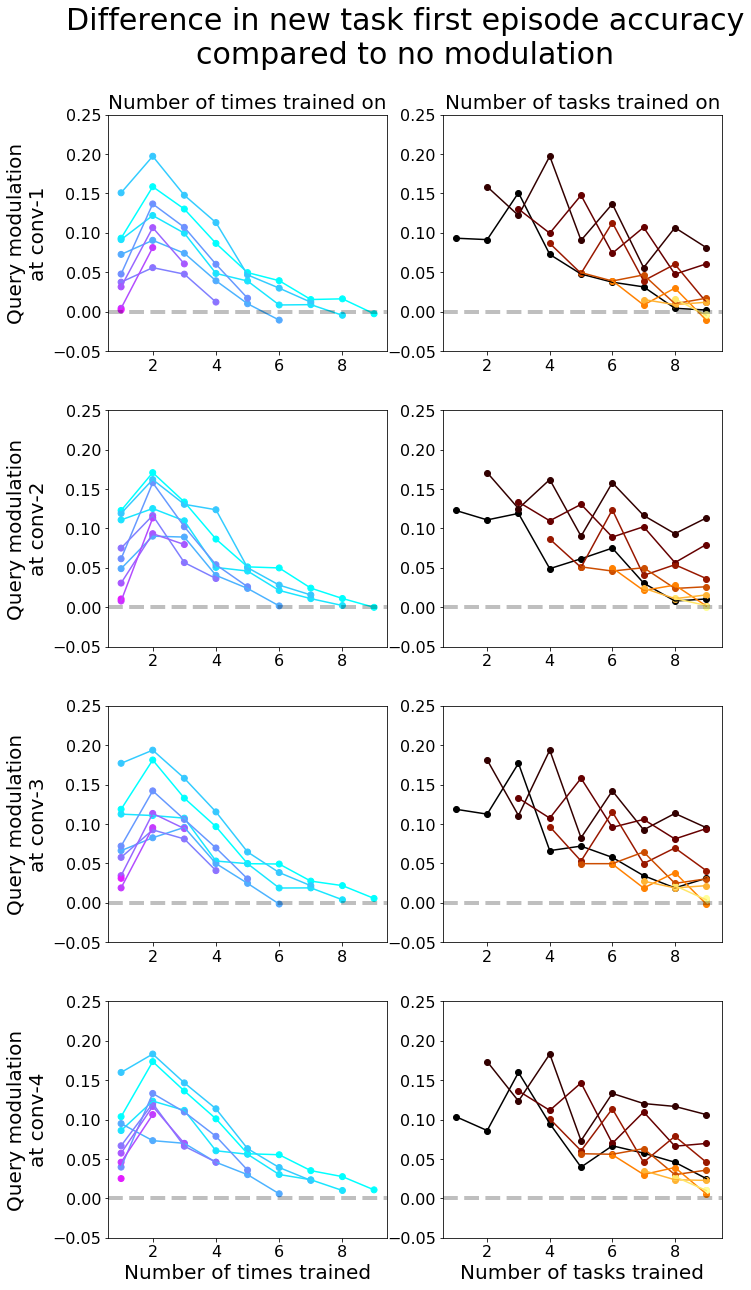

In [95]:
comparison_level = 0

ACCURACY_DIFFERNCE_YLIM = (-0.05, 0.25)

plots.combined_comparison_plots(six_replications_analyses, query_mod_replications, 
                                'Difference in new task first episode accuracy\ncompared to no modulation',
                                comparison_level, comparison_func=np.subtract,
                                font_dict=FONT_DICT, comparison_first=False, ylim=ACCURACY_DIFFERNCE_YLIM, data_index=2, 
                                log_x=False, log_y=False, shade_error=False, 
                                times_trained_colormap='cool', tasks_trained_colormap='afmhot')

# Sign-test for the comparisons - see which model wins more often

**Mike** - I implemented two variations on the sign test. One just looking at which one is better, and one also enforcing the SEMs around each mean. Which one makes more sense to report? Or both?

In [173]:
sign_test_examples = [six_replications_analyses.combined.examples]
sign_test_examples.extend([query_mod_replications[rep_index].combined.examples for rep_index in query_mod_replications])


def sign_test(values):
    n = len(values)
    row_faster_results = np.empty((n, n))
    row_faster_results.fill(np.nan)
    
    col_faster_results = np.empty((n, n))
    col_faster_results.fill(np.nan)
    
    wilcoxon_statistics = np.empty((n, n))
    wilcoxon_statistics.fill(np.nan)
    
    wilcoxon_p_values = np.empty((n, n))
    wilcoxon_p_values.fill(np.nan)
    
    for row in range(n):
        for col in range(row + 1, n):
            row_means = values[row].mean
            row_means = row_means[~np.isnan(row_means)]
            col_means = values[col].mean
            col_means = col_means[~np.isnan(col_means)]
    
            # Run both explicit comparisons, to account for the possibility of ties
            row_faster = np.sum(row_means <col_means )
            row_faster_results[row, col] = row_faster
            
            col_faster = np.sum(row_means > col_means)
            col_faster_results[row, col] = col_faster
            
            s, p = wilcoxon(row_means, col_means)
            wilcoxon_statistics[row, col] = s
            wilcoxon_p_values[row, col] = p
            
    return row_faster_results, col_faster_results, wilcoxon_statistics, wilcoxon_p_values


MODULATION_LEVELS = ['None'] + [str(i) for i in range(1, 5)] 
SIGN_TEST_PRINT_HEADERS = ['Modulation level'] + [str(i) for i in range(1, 5)] 


def pretty_print_sign_test_results(row_faster_results, col_faster_results, 
                                   wilcoxon_statistics=None, wilcoxon_p_values=None,
                                   higher_better=False, sign_test_n = 55, **kwargs):
    n = row_faster_results.shape[0]
    print_results = [[''] * n for _ in range(n)]
    if wilcoxon_statistics is not None:
        wilcoxon_results = [[''] * n for _ in range(n)]
    
    for row in range(n):
        for col in range(row + 1, n):
            row_val = int(row_faster_results[row, col])
            col_val = int(col_faster_results[row, col])
            if higher_better:
                row_val, col_val = col_val, row_val
                
            result = col_val - row_val
            p = binom_test(abs(result), sign_test_n)
            
            print_results[row][col] = f'{result} ({col_val}-{row_val}, p={p:.3f})'
            
            if wilcoxon_statistics is not None:
                wilcoxon_results[row][col] = f'\n{wilcoxon_statistics[row, col]:.4f}, {wilcoxon_p_values[row, col]:.4f}'
            
    tab_args = dict(tablefmt='fancy_grid')
    tab_args.update(kwargs)
            
    print_results = [[MODULATION_LEVELS[i]] + row[1:] for i, row in enumerate(print_results)]
    print(tabulate.tabulate(print_results[:-1], SIGN_TEST_PRINT_HEADERS, **tab_args))
    
    if wilcoxon_statistics is not None:
        wilcoxon_results = [[MODULATION_LEVELS[i]] + row[1:] for i, row in enumerate(wilcoxon_results)]
        print(tabulate.tabulate(wilcoxon_results[:-1], SIGN_TEST_PRINT_HEADERS, **tab_args))
    
    
row_faster_results, col_faster_results, wilcoxon_statistics, wilcoxon_p_values = sign_test(sign_test_examples)
pretty_print_sign_test_results(row_faster_results, col_faster_results, wilcoxon_statistics, wilcoxon_p_values)

╒════════════════════╤═════════════════════╤═════════════════════╤═════════════════════╤═════════════════════╕
│ Modulation level   │ 1                   │ 2                   │ 3                   │ 4                   │
╞════════════════════╪═════════════════════╪═════════════════════╪═════════════════════╪═════════════════════╡
│ None               │ -1 (27-28, p=0.000) │ 19 (37-18, p=0.030) │ 33 (44-11, p=0.177) │ 47 (51-4, p=0.000)  │
├────────────────────┼─────────────────────┼─────────────────────┼─────────────────────┼─────────────────────┤
│ 1                  │                     │ 31 (43-12, p=0.419) │ 47 (51-4, p=0.000)  │ 55 (55-0, p=0.000)  │
├────────────────────┼─────────────────────┼─────────────────────┼─────────────────────┼─────────────────────┤
│ 2                  │                     │                     │ 24 (38-14, p=0.419) │ 40 (46-6, p=0.001)  │
├────────────────────┼─────────────────────┼─────────────────────┼─────────────────────┼─────────────────────┤
│

## Sign test enforcing a margin of error

In [174]:
sign_test_log_examples = [six_replications_analyses.combined.log_examples]
sign_test_log_examples.extend([query_mod_replications[rep_index].combined.log_examples
                               for rep_index in query_mod_replications])


def sign_test_with_sem(values, sample_sizes):
    n = len(values)
    row_faster_results = np.empty((n, n))
    row_faster_results.fill(np.nan)
    
    col_faster_results = np.empty((n, n))
    col_faster_results.fill(np.nan)
    
    wilcoxon_statistics = np.empty((n, n))
    wilcoxon_statistics.fill(np.nan)
    
    wilcoxon_p_values = np.empty((n, n))
    wilcoxon_p_values.fill(np.nan)
    
    for row in range(n):
        for col in range(row, n):
            row_means = values[row].mean
            row_means = row_means[~np.isnan(row_means)]
            row_sems = values[row].std / (sample_sizes[row] ** 0.5)
            row_sems = row_sems[~np.isnan(row_sems)]
            
            col_means = values[col].mean
            col_means = col_means[~np.isnan(col_means)]
            col_sems = values[col].std / (sample_sizes[col] ** 0.5)
            col_sems = col_sems[~np.isnan(col_sems)]
    
            # Run both explicit comparisons, to account for the possibility of ties
            row_faster_results[row, col] = np.sum(row_means + row_sems < col_means - col_sems)
            col_faster_results[row, col] = np.sum(row_means - row_sems > col_means + col_sems)
            
            signs = row_means < col_means
            signs[signs == 0] = -1
            
            shifted_row_means = row_means + np.multiply(row_sems, signs)
            shifted_col_means = col_means + np.multiply(col_sems, -1 * signs)
            s, p = wilcoxon(shifted_row_means, shifted_col_means)
            wilcoxon_statistics[row, col] = s
            wilcoxon_p_values[row, col] = p
            
    return row_faster_results, col_faster_results, wilcoxon_statistics, wilcoxon_p_values


row_faster_results, col_faster_results, wilcoxon_statistics, wilcoxon_p_values = sign_test_with_sem(sign_test_examples, [180] + [60] * 4)
pretty_print_sign_test_results(row_faster_results, col_faster_results, wilcoxon_statistics, wilcoxon_p_values)

╒════════════════════╤═══════════════════╤════════════════════╤════════════════════╤════════════════════╕
│ Modulation level   │ 1                 │ 2                  │ 3                  │ 4                  │
╞════════════════════╪═══════════════════╪════════════════════╪════════════════════╪════════════════════╡
│ None               │ 7 (12-5, p=0.000) │ 16 (17-1, p=0.003) │ 26 (26-0, p=0.788) │ 29 (29-0, p=0.788) │
├────────────────────┼───────────────────┼────────────────────┼────────────────────┼────────────────────┤
│ 1                  │                   │ 1 (2-1, p=0.000)   │ 7 (7-0, p=0.000)   │ 12 (12-0, p=0.000) │
├────────────────────┼───────────────────┼────────────────────┼────────────────────┼────────────────────┤
│ 2                  │                   │                    │ 2 (2-0, p=0.000)   │ 4 (4-0, p=0.000)   │
├────────────────────┼───────────────────┼────────────────────┼────────────────────┼────────────────────┤
│ 3                  │                   │    

## Sign test on the first episode accuracies

In [175]:
sign_test_accuracies = [six_replications_analyses.combined.accuracies]
sign_test_accuracies.extend([query_mod_replications[rep_index].combined.accuracies 
                             for rep_index in query_mod_replications])

row_faster_results, col_faster_results, wilcoxon_statistics, wilcoxon_p_values = sign_test(sign_test_accuracies)
pretty_print_sign_test_results(row_faster_results, col_faster_results, wilcoxon_statistics, wilcoxon_p_values, True)

╒════════════════════╤════════════════════╤═════════════════════╤═════════════════════╤═════════════════════╕
│ Modulation level   │ 1                  │ 2                   │ 3                   │ 4                   │
╞════════════════════╪════════════════════╪═════════════════════╪═════════════════════╪═════════════════════╡
│ None               │ 39 (42-3, p=0.003) │ 43 (44-1, p=0.000)  │ 43 (44-1, p=0.000)  │ 45 (45-0, p=0.000)  │
├────────────────────┼────────────────────┼─────────────────────┼─────────────────────┼─────────────────────┤
│ 1                  │                    │ 21 (33-12, p=0.105) │ 35 (40-5, p=0.058)  │ 31 (38-7, p=0.419)  │
├────────────────────┼────────────────────┼─────────────────────┼─────────────────────┼─────────────────────┤
│ 2                  │                    │                     │ 17 (31-14, p=0.006) │ 23 (34-11, p=0.281) │
├────────────────────┼────────────────────┼─────────────────────┼─────────────────────┼─────────────────────┤
│ 3       

## and with the SEM

In [176]:
row_faster_results, col_faster_results, wilcoxon_statistics, wilcoxon_p_values = sign_test_with_sem(sign_test_accuracies, [180] + [60] * 4)
pretty_print_sign_test_results(row_faster_results, col_faster_results, wilcoxon_statistics, wilcoxon_p_values, True)

╒════════════════════╤════════════════════╤════════════════════╤════════════════════╤════════════════════╕
│ Modulation level   │ 1                  │ 2                  │ 3                  │ 4                  │
╞════════════════════╪════════════════════╪════════════════════╪════════════════════╪════════════════════╡
│ None               │ 34 (34-0, p=0.105) │ 38 (38-0, p=0.006) │ 42 (42-0, p=0.000) │ 42 (42-0, p=0.000) │
├────────────────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┤
│ 1                  │                    │ 2 (2-0, p=0.000)   │ 4 (4-0, p=0.000)   │ 10 (10-0, p=0.000) │
├────────────────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┤
│ 2                  │                    │                    │ 1 (1-0, p=0.000)   │ 6 (6-0, p=0.000)   │
├────────────────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┤
│ 3                  │               